<a href="https://colab.research.google.com/github/PashaIanko/Kaggle.DigitRecognizer/blob/main/0_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
from google.colab import drive

## Pep 8 standard

In [2]:
%%capture 
try: 
    from nbpep8.nbpep8 import pep8 
except ModuleNotFoundError: 
    !pip install pycodestyle 
    !pip install --index-url https://test.pypi.org/simple/ nbpep8
from nbpep8.nbpep8 import pep8

## Custom packages

In [3]:
%%capture
def download_files(url_dict):
    for file, url in url_dict.items():
        print(f'Downloading {file}')
        !wget -O {file} {url} {file}

git_download_path = \
'https://raw.githubusercontent.com/PashaIanko/Sklearn-Utils/main/'

files = [
    'path_manager.py',
    'sklearn_transformers.py',
    'sklearn_utils.py'
]

url_dict = {file: git_download_path + file for file in files}
download_files(url_dict)

In [4]:
import importlib
import path_manager
import sklearn_utils

def reload_all(modules_list_):
    for module in modules_list_:
        importlib.reload(module)

reload_all(
    [
        path_manager,
        sklearn_utils
        # other modules
    ]
)

from path_manager import PathManager
from sklearn_utils import (
    nan_statistics,
    visualize_datasets_distributions
)

# Setup paths

In [10]:
drive.mount('/content/gdrive', force_remount=True)  # force_remount=True
gdrive_path = '/content/gdrive/MyDrive/'

PREPROC_TRIAL = 'baseline'
MODELS_TRIAL = 'baseline'
COMPETITION_PATH = gdrive_path + 'ML/Competitions/3.DigitRecognizer/'

manager = PathManager(
    competition_path=COMPETITION_PATH,
    preprocessing_trial=PREPROC_TRIAL,
    models_trial=MODELS_TRIAL
)
manager.setup_paths()

Mounted at /content/gdrive


# Download the data

In [82]:
import pandas as pd
df_train = pd.read_csv(manager.train_path)
df_train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [83]:
df_test = pd.read_csv(manager.test_path)
df_test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Quick data exporation

## Nan values

In [28]:
assert not df_train.isna().any().any()
assert not df_test.isna().any().any()

In [32]:
import numpy as np
print(np.max(df_train.values), np.min(df_train.values))
print(np.max(df_test.values), np.min(df_test.values))

255 0
255 0


## Class balance

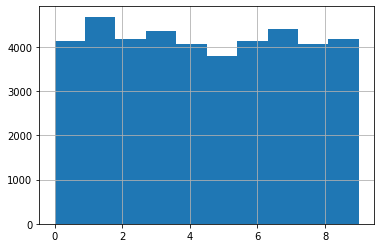

In [37]:
import matplotlib.pyplot as plt

_, ax = plt.subplots()
df_train['label'].hist(ax=ax)

# Create train, validation and test sets

In [86]:
from sklearn.model_selection import train_test_split

TRAINVAL_SIZE = 0.8
RANDOM_STATE = 42

df_trainval, df_test_sample = train_test_split(
    df_train,
    train_size=TRAINVAL_SIZE,
    random_state=RANDOM_STATE,
    stratify=df_train['label']
)
df_trainval.shape, df_test.shape

((21504, 785), (28000, 784))

In [87]:
TRAIN_SIZE = 0.8

df_train, df_val = train_test_split(
    df_trainval,
    train_size=TRAIN_SIZE,
    random_state=RANDOM_STATE,
    stratify=df_trainval['label']
)
df_train.shape, df_val.shape

((17203, 785), (4301, 785))

# Data exploration (from now on, on train set)

In [44]:
vals = df_train.values[0, 1:]
type(vals)

numpy.ndarray

(-0.5, 27.5, 27.5, -0.5)

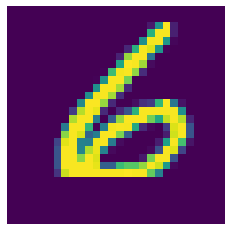

In [46]:
plt.imshow(vals.reshape(28, 28))
plt.axis('off')

# Data preparation

In [88]:
df_test.shape, df_test_sample.shape

((28000, 784), (5376, 785))

In [89]:
df_train.values[:, 1:] = df_train.values[:, 1:] / 255.0
df_val.values[:, 1:] = df_val.values[:, 1:] / 255.0
df_test_sample.values[:, 1:] = df_test_sample.values[:, 1:] / 255.0

df_test.values[:, :] = df_test.values[:, :] / 255.0

In [92]:
assert df_train.values[:, 1:].max() <= 1.0
assert df_test.values.max() <= 1.0
assert df_test_sample.values[:, 1:].max() <= 1.0
assert df_val.values[:, 1:].max()

In [93]:
df_test_sample.values.max()

9

# Save data

In [94]:
manager.save_to_csv(
    df_train,
    manager.data_trial_path,
    'train_processed.csv'
)

manager.save_to_csv(
    df_val,
    manager.data_trial_path,
    'val_processed.csv'
)

In [95]:
manager.save_to_csv(
    df_test_sample,
    manager.data_trial_path,
    'test_sample_processed.csv'
)

In [96]:
manager.save_to_csv(
    df_test,
    manager.data_trial_path,
    'test_processed.csv'
)

# Model preparation

In [101]:
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Sequential

In [106]:
df_train.label.unique()

array([1, 9, 3, 5, 8, 4, 7, 6, 2, 0])

In [122]:
baseline_model = Sequential(
    [
        layers.Input(shape=(784, )),
        layers.Dense(units=784, activation='relu'),
        layers.Dense(units=100, activation='relu'),
        layers.Dense(units=10, activation='softmax')
    ]
)

In [123]:
baseline_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [144]:
X_train = df_train.values[:, 1:]
Y_train = df_train.values[:, 0]

X_validation = df_val.values[:, 1:]
Y_validation = df_val.values[:, 0]

X_test_sample = df_test_sample.values[:, 1:]
Y_test_sample = df_test_sample.values[:, 0]

X_test = df_test.values[:, :]

assert X_train.shape[1] == X_validation.shape[1] == X_test.shape[1]

In [147]:
assert (np.unique(Y_train) == np.unique(Y_validation)).all()
assert (np.unique(Y_validation) == np.unique(Y_test_sample)).all()

In [148]:
history = baseline_model.fit(
    X_train,
    Y_train,
    validation_data=(X_validation, Y_validation),
    batch_size=32,
    epochs=5
)

Epoch 1/5
538/538 [==============================] - 6s 11ms/step - loss: 1.3114 - accuracy: 0.5136 - val_loss: 1.7903 - val_accuracy: 0.4013
Epoch 2/5
538/538 [==============================] - 5s 9ms/step - loss: 1.3000 - accuracy: 0.5124 - val_loss: 1.8018 - val_accuracy: 0.3964
Epoch 3/5
538/538 [==============================] - 5s 8ms/step - loss: 1.2941 - accuracy: 0.5113 - val_loss: 1.8159 - val_accuracy: 0.3962
Epoch 4/5
538/538 [==============================] - 5s 9ms/step - loss: 1.2870 - accuracy: 0.5154 - val_loss: 1.8308 - val_accuracy: 0.3941
Epoch 5/5
538/538 [==============================] - 5s 8ms/step - loss: 1.2822 - accuracy: 0.5175 - val_loss: 1.8440 - val_accuracy: 0.3980


In [149]:
baseline_model.evaluate(
    X_validation,
    Y_validation
)

135/135 [==============================] - 1s 9ms/step - loss: 1.8440 - accuracy: 0.3980


[1.8440223932266235, 0.39804697036743164]

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

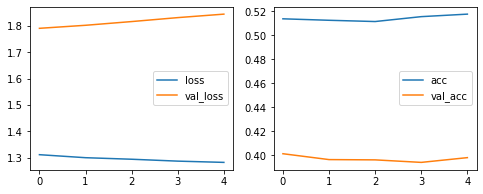

In [153]:
_, ax = plt.subplots(1, 2, figsize=(8, 3))

ax[0].plot(
    history.history['loss'],
    label='loss'
)
ax[0].plot(
    history.history['val_loss'],
    label='val_loss'
)

ax[0].legend()

ax[1].plot(
    history.history['accuracy'],
    label='acc'
)
ax[1].plot(
    history.history['val_accuracy'],
    label='val_acc'
)
ax[1].legend()

history.history.keys()